#About Dataset

link https://www.kaggle.com/datasets/zadafiyabhrami/global-crocodile-species-dataset


This dataset provides detailed information on all recognized crocodile species across the globe. It includes taxonomic classification, geographic distribution, habitat details, population estimates, and conservation statuses. The dataset is designed to support tasks such as clustering, classification, ecological modeling, and conservation analysis. It can also be used for machine learning applications in species recognition, predictive habitat modeling, and biodiversity research.

##Imports

In [32]:
import pandas as pd
import numpy as np
import kagglehub
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

try:
    from xgboost import XGBClassifier
    HAVE_XGB = True
except:
    HAVE_XGB = False
from sklearn.preprocessing import LabelEncoder

##Load the data

In [2]:
# Download latest version
path = kagglehub.dataset_download("zadafiyabhrami/global-crocodile-species-dataset")

print("Path to dataset files:", path)

100%|██████████| 56.1k/56.1k [00:00<00:00, 28.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/zadafiyabhrami/global-crocodile-species-dataset/versions/1


In [3]:
# List files in the dataset directory
print(os.listdir(path))

['crocodile_dataset.csv']


In [4]:
df = pd.read_csv(f"{path}/crocodile_dataset.csv")
display(df.head())

,Observation ID,Common Name,Scientific Name,Family,Genus,Observed Length (m),Observed Weight (kg),Age Class,Sex,Date of Observation,Country/Region,Habitat Type,Conservation Status,Observer Name,Notes
0,1,Morelet's Crocodile,Crocodylus moreletii,Crocodylidae,Crocodylus,1.90,62.0,Adult,Male,31-03-2018,Belize,Swamps,Least Concern,Allison Hill,Cause bill scientist nation opportunity.
1,2,American Crocodile,Crocodylus acutus,Crocodylidae,Crocodylus,4.09,334.5,Adult,Male,28-01-2015,Venezuela,Mangroves,Vulnerable,Brandon Hall,Ago current practice nation determine operatio...
2,3,Orinoco Crocodile,Crocodylus intermedius,Crocodylidae,Crocodylus,1.08,118.2,Juvenile,Unknown,07-12-2010,Venezuela,Flooded Savannas,Critically Endangered,Melissa Peterson,Democratic shake bill here grow gas enough ana...
3,4,Morelet's Crocodile,Crocodylus moreletii,Crocodylidae,Crocodylus,2.42,90.4,Adult,Male,01-11-2019,Mexico,Rivers,Least Concern,Edward Fuller,Officer relate animal direction eye bag do.
4,5,Mugger Crocodile (Marsh Crocodile),Crocodylus palustris,Crocodylidae,Crocodylus,3.75,269.4,Adult,Unknown,15-07-2019,India,Rivers,Vulnerable,Donald Reid,Class great prove reduce raise author play mov...


##Explore the data

In [5]:
df.columns

Index(['Observation ID', 'Common Name', 'Scientific Name', 'Family', 'Genus',
       'Observed Length (m)', 'Observed Weight (kg)', 'Age Class', 'Sex',
       'Date of Observation', 'Country/Region', 'Habitat Type',
       'Conservation Status', 'Observer Name', 'Notes'],
      dtype='object')

In [6]:
df.isnull().sum().sum()

np.int64(0)

In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
df.shape

(1000, 15)

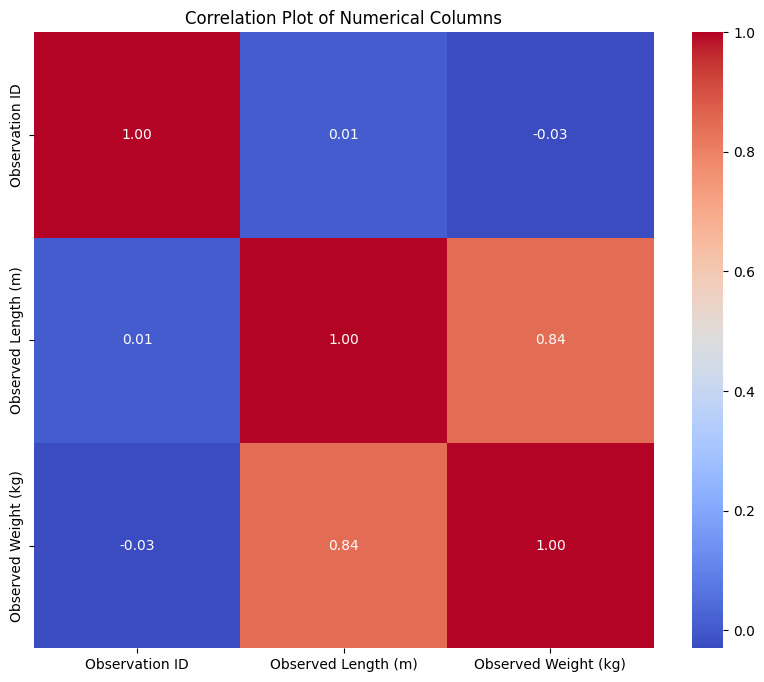

In [9]:
# Calculate the correlation matrix
correlation_matrix = df.select_dtypes(include=['number']).corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Plot of Numerical Columns')
plt.show()

In [10]:
df["Notes"][200]

'Will young simply run national somebody character usually agency must.'

##Preprocessing


In [11]:
df = df.drop(columns=['Observation ID','Date of Observation', 'Common Name','Observer Name', 'Notes'])

In [12]:
df

,Scientific Name,Family,Genus,Observed Length (m),Observed Weight (kg),Age Class,Sex,Country/Region,Habitat Type,Conservation Status
0,Crocodylus moreletii,Crocodylidae,Crocodylus,1.90,62.0,Adult,Male,Belize,Swamps,Least Concern
1,Crocodylus acutus,Crocodylidae,Crocodylus,4.09,334.5,Adult,Male,Venezuela,Mangroves,Vulnerable
2,Crocodylus intermedius,Crocodylidae,Crocodylus,1.08,118.2,Juvenile,Unknown,Venezuela,Flooded Savannas,Critically Endangered
3,Crocodylus moreletii,Crocodylidae,Crocodylus,2.42,90.4,Adult,Male,Mexico,Rivers,Least Concern
4,Crocodylus palustris,Crocodylidae,Crocodylus,3.75,269.4,Adult,Unknown,India,Rivers,Vulnerable
...,...,...,...,...,...,...,...,...,...,...
995,Crocodylus suchus,Crocodylidae,Crocodylus,2.55,112.3,Adult,Female,Mauritania,Lakes,Least Concern
996,Crocodylus halli,Crocodylidae,Crocodylus,2.27,80.3,Subadult,Female,Papua New Guinea,Freshwater Wetlands,Least Concern
997,Mecistops cataphractus,Crocodylidae,Mecistops,2.34,93.5,Adult,Male,Côte d'Ivoire,Swamps,Critically Endangered
998,Mecistops cataphractus,Crocodylidae,Mecistops,2.82,147.6,Adult,Male,Sierra Leone,Shaded Forest Rivers,Critically Endangered


In [13]:
df['Scientific Name'].value_counts()

,count
Scientific Name,
Crocodylus novaeguineae,68
Crocodylus raninus,67
Crocodylus acutus,66
Crocodylus moreletii,64
Crocodylus rhombifer,59
Crocodylus intermedius,58
Crocodylus mindorensis,58
Crocodylus porosus,58
Osteolaemus tetraspis,57


In [14]:
# Map 'Sex' values to numerical representation
sex_mapping = {'Unknown': 0, 'Male': 1, 'Female': 2}
df['Sex'] = df['Sex'].map(sex_mapping)
display(df.head())

,Scientific Name,Family,Genus,Observed Length (m),Observed Weight (kg),Age Class,Sex,Country/Region,Habitat Type,Conservation Status
0,Crocodylus moreletii,Crocodylidae,Crocodylus,1.90,62.0,Adult,1,Belize,Swamps,Least Concern
1,Crocodylus acutus,Crocodylidae,Crocodylus,4.09,334.5,Adult,1,Venezuela,Mangroves,Vulnerable
2,Crocodylus intermedius,Crocodylidae,Crocodylus,1.08,118.2,Juvenile,0,Venezuela,Flooded Savannas,Critically Endangered
3,Crocodylus moreletii,Crocodylidae,Crocodylus,2.42,90.4,Adult,1,Mexico,Rivers,Least Concern
4,Crocodylus palustris,Crocodylidae,Crocodylus,3.75,269.4,Adult,0,India,Rivers,Vulnerable


In [15]:
Age_mapping = {'Adult': 0, 'Subadult': 1, 'Juvenile': 2,"Hatchling": 3}
df['Age Class'] = df['Age Class'].map(Age_mapping)
display(df.head())

,Scientific Name,Family,Genus,Observed Length (m),Observed Weight (kg),Age Class,Sex,Country/Region,Habitat Type,Conservation Status
0,Crocodylus moreletii,Crocodylidae,Crocodylus,1.90,62.0,0,1,Belize,Swamps,Least Concern
1,Crocodylus acutus,Crocodylidae,Crocodylus,4.09,334.5,0,1,Venezuela,Mangroves,Vulnerable
2,Crocodylus intermedius,Crocodylidae,Crocodylus,1.08,118.2,2,0,Venezuela,Flooded Savannas,Critically Endangered
3,Crocodylus moreletii,Crocodylidae,Crocodylus,2.42,90.4,0,1,Mexico,Rivers,Least Concern
4,Crocodylus palustris,Crocodylidae,Crocodylus,3.75,269.4,0,0,India,Rivers,Vulnerable


In [16]:
# Initialize LabelEncoder
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])

In [18]:
df

,Scientific Name,Family,Genus,Observed Length (m),Observed Weight (kg),Age Class,Sex,Country/Region,Habitat Type,Conservation Status
0,5,0,0,1.90,62.0,0,1,1,27,3
1,0,0,0,4.09,334.5,0,1,45,16,4
2,2,0,0,1.08,118.2,2,0,45,6,0
3,5,0,0,2.42,90.4,0,1,29,22,3
4,8,0,0,3.75,269.4,0,0,17,22,4
...,...,...,...,...,...,...,...,...,...,...
995,13,0,0,2.55,112.3,0,2,28,14,3
996,1,0,0,2.27,80.3,1,2,34,11,3
997,14,0,1,2.34,93.5,0,1,11,27,0
998,14,0,1,2.82,147.6,0,1,37,23,0


##Training and building the model

In [17]:
X = df.drop('Scientific Name', axis =1)
y = df['Scientific Name']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

In [23]:
models = {
    "LogReg": LogisticRegression(multi_class="multinomial", max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

if HAVE_XGB:
    models["XGBoost"] = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)


### Training & Evaluation

In [37]:
results = []
labels_all = np.arange(len(le.classes_))
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append((name, acc))

    print(f"\n{name} Accuracy: {acc:.3f}")
    print(classification_report(y_test, y_pred))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



LogReg Accuracy: 0.796
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        17
           1       0.57      0.67      0.62        12
           2       1.00      1.00      1.00        14
           3       0.92      1.00      0.96        11
           4       0.79      1.00      0.88        15
           5       0.67      0.62      0.65        16
           6       0.82      0.75      0.78        12
           7       0.32      0.41      0.36        17
           8       0.71      0.83      0.77        12
           9       0.80      0.86      0.83        14
          10       0.88      0.82      0.85        17
          11       0.81      0.87      0.84        15
          12       0.50      0.27      0.35        11
          13       0.83      0.38      0.53        13
          14       1.00      1.00      1.00        14
          15       1.00      1.00      1.00        14
          16       1.00      1.00      1.00        12
   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/xgboost/t


XGBoost Accuracy: 0.988
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.91      0.83      0.87        12
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        16
           6       1.00      1.00      1.00        12
           7       0.89      0.94      0.91        17
           8       1.00      1.00      1.00        12
           9       1.00      1.00      1.00        14
          10       1.00      1.00      1.00        17
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        11
          13       1.00      1.00      1.00        13
          14       1.00      1.00      1.00        14
          15       1.00      1.00      1.00        14
          16       1.00      1.00      1.00        12
  

### Best Model Selection

In [42]:
# Sort results by accuracy in descending order
sorted_results = sorted(results, key=lambda x: x[1], reverse=True)

print("Model Performance:")
for name, acc in sorted_results:
    print(f"- {name}: {acc:.3f}")

# Identify the best model(s)
best_acc = sorted_results[0][1]
best_models = [name for name, acc in sorted_results if acc == best_acc]

print("\nBest Model(s) based on Accuracy:")
for model_name in best_models:
    print(f"- {model_name}")

Model Performance:
- DecisionTree: 0.988
- XGBoost: 0.988
- GradientBoosting: 0.984
- RandomForest: 0.952
- LogReg: 0.796
- KNN: 0.544
- SVM: 0.288

Best Model(s) based on Accuracy:
- DecisionTree
- XGBoost
